In [1]:
# !pip install torch numpy gym matplotlib gymnasium

# VPG implementation from scratch

- We need the following:
1. Policy network
2. Value network
3. Enviroment
4. Training loop

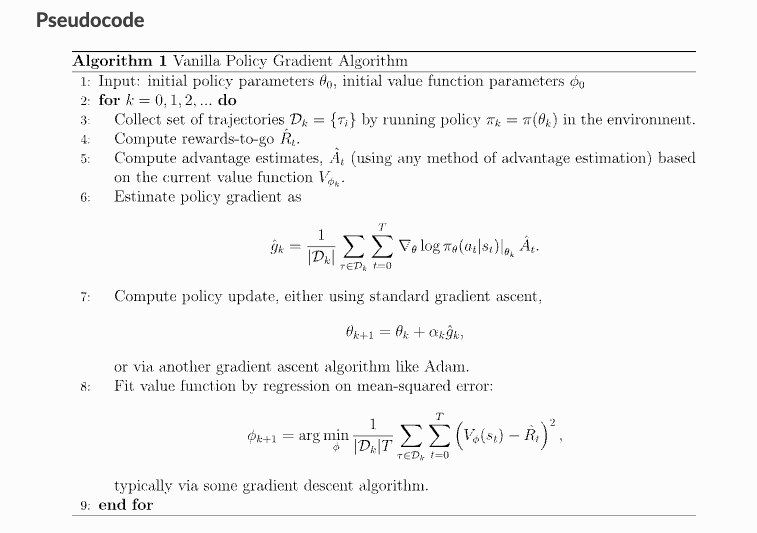
### What is happening in the pseudocode?
1. Initialize policy parameters and value function parameters
2. For every episode, do the following:
   - Collect a set of trajectories(s, r, a, s'), you can also store experience(s, a, s') in a memory buffer
   - After each episode has reached a terminal state or exceeded the number of steps set for exploration in the environment,
   - Compute reward-to-go(Cummulative reward from a partcular state computed at every step the agent makes in the episode)
   - Compute advantage estimate to help focus on `better-than-expected` action taken in each step in the episode
   - Update policy parameters based on the `utility function`(Similar to how loss is used to update gradients in LLM)
   - Update value function using `mean-squared-error` in order to make value function get better at estimating reward for each step taken by the agent on an episode
   - End after loop over number of episodes is done
   

In [1]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import gymnasium as gym
from collections import deque
import random
import matplotlib.pyplot as plt 

### Policy network

In [5]:
class PolicyNetwork(nn.Module):
    def __init__(self, obs_dim, n_hidden, n_actions):
        super().__init__()
        self.linear1 = nn.Linear(obs_dim, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_actions)
        self.rewards, self.saved_actions = [], []

    def forward(self, x):
        out = F.relu(self.linear1(x))
        out = self.linear2(out)
        aprob = F.softmax(out, dim=1)
        return aprob

### Value network

In [6]:
class ValueNetwork(nn.Module):
    def __init__(self, obs_dim, n_hidden):
        super().__init__()
        self.linear1 = nn.Linear(obs_dim, n_hidden)
        self.linear2 = nn.Linear(n_hidden, 1)

    def forward(self, x):
        out = F.relu(self.linear1(x))
        V = self.linear2(out)
        return V

### Training loop

#### Vanilla policy gradient

In [7]:
# Create environment
env = gym.make("CartPole-v1") # sample toy environment

# Instantiate policy and value network
print(f"Number of observations and actions in cartpole env: {env.observation_space.shape[0]}, {env.action_space.n}")
policy = PolicyNetwork(obs_dim=env.observation_space.shape[0], n_hidden=64, n_actions=env.action_space.n)
value = ValueNetwork(obs_dim=env.observation_space.shape[0], n_hidden=64)

# Instantiate an optimizer
policy_optimizer = torch.optim.SGD(policy.parameters(), lr=2e-7)
value_optimizer = torch.optim.SGD(value.parameters(), lr=1e-7)
# policy_optimizer = torch.optim.Adam(policy.parameters(), lr=2e-6)
# value_optimizer = torch.optim.Adam(value.parameters(), lr=1e-6)

# Initialize gamma and stat
gamma = 0.99
n_episodes = 5000 # 5000
returns = deque(maxlen=100)
memory_buffer = deque(maxlen=2000)
to_plot_avgreturn = []
to_plot_utility = []
to_plot_value_loss = []

for n_episode in range(n_episodes):
    rewards, actions, states = [], [], []
    # Reset environment
    state, _ = env.reset()
    done = False

    while not done:
        # Collect action probabilities from policy function
        probs = policy(torch.tensor(state).unsqueeze(0).float())

        # Sample an action from the policy
        action_distibution = Categorical(probs)
        action = action_distibution.sample()

        # Take that action in the environment
        new_state, reward, terminated, truncated, info = env.step(action.item())
        done = terminated or truncated  # Combine termination signals

        # Store state, action and reward
        states.append(state)
        actions.append(action)
        rewards.append(reward)

        memory_buffer.append((state, reward, new_state))

        state = new_state

    #############################
    ### UPDATE POLICY NETWORK ###
    rewards = np.array(rewards)
    # Calculate rewards-to-go
    R = torch.tensor([np.sum(rewards[i:]*(gamma**np.array(range(i, len(rewards))))) for i in range(len(rewards))])

    # Cast states and actions to tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.float32)

    # Calculate baseline V(s)
    with torch.no_grad():
        baseline = value(states)

    # Calculate utility function
    probs = policy(states)
    sampler = Categorical(probs)
    log_probs = -sampler.log_prob(actions) # "-" is because we are doing gradient ascent
    utility = torch.sum(log_probs * (R - baseline)) # loss that when differentiated with autograd gives the gradient of J(θ)

    # Update policy weights
    policy_optimizer.zero_grad()
    utility.backward()
    policy_optimizer.step()

    ############################################
    ###     UPDATE VALUE NETWORK            ####


    # Getting batch experience data
    batch_experience = random.sample(list(memory_buffer), min(256, len(memory_buffer)))
    state_batch = torch.tensor([exp[0] for exp in batch_experience])
    reward_batch = torch.tensor([exp[1] for exp in batch_experience]).view(-1, 1)
    new_state_batch = torch.tensor([exp[2] for exp in batch_experience])

    with torch.no_grad():
        target = reward_batch + gamma*value(new_state_batch)
    current_state_value = value(new_state_batch)

    value_loss = torch.nn.functional.mse_loss(current_state_value, target)
    # Update value weights
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    to_plot_avgreturn.append(np.mean(returns))
    to_plot_utility.append(utility.item())
    to_plot_value_loss.append(value_loss.item())

    ###################################################
    # Calculate average return and print it out
    returns.append(np.sum(rewards))

    if n_episode % 100 == 0:
        print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))

# Close environment
env.close()

Number of observations and actions in cartpole env: 4, 2
Episode:      0	Avg. Return:  15.00
Episode:    100	Avg. Return:  18.53
Episode:    200	Avg. Return:  20.68
Episode:    300	Avg. Return:  18.64
Episode:    400	Avg. Return:  21.14
Episode:    500	Avg. Return:  22.26
Episode:    600	Avg. Return:  24.13
Episode:    700	Avg. Return:  24.16
Episode:    800	Avg. Return:  23.93
Episode:    900	Avg. Return:  25.16
Episode:   1000	Avg. Return:  22.03
Episode:   1100	Avg. Return:  27.83
Episode:   1200	Avg. Return:  27.96
Episode:   1300	Avg. Return:  27.21
Episode:   1400	Avg. Return:  31.20
Episode:   1500	Avg. Return:  33.18
Episode:   1600	Avg. Return:  32.16
Episode:   1700	Avg. Return:  32.92
Episode:   1800	Avg. Return:  35.19
Episode:   1900	Avg. Return:  37.19
Episode:   2000	Avg. Return:  40.65
Episode:   2100	Avg. Return:  45.43
Episode:   2200	Avg. Return:  43.80
Episode:   2300	Avg. Return:  39.85
Episode:   2400	Avg. Return:  51.74
Episode:   2500	Avg. Return:  51.27
Episode

### Make some interesting plots

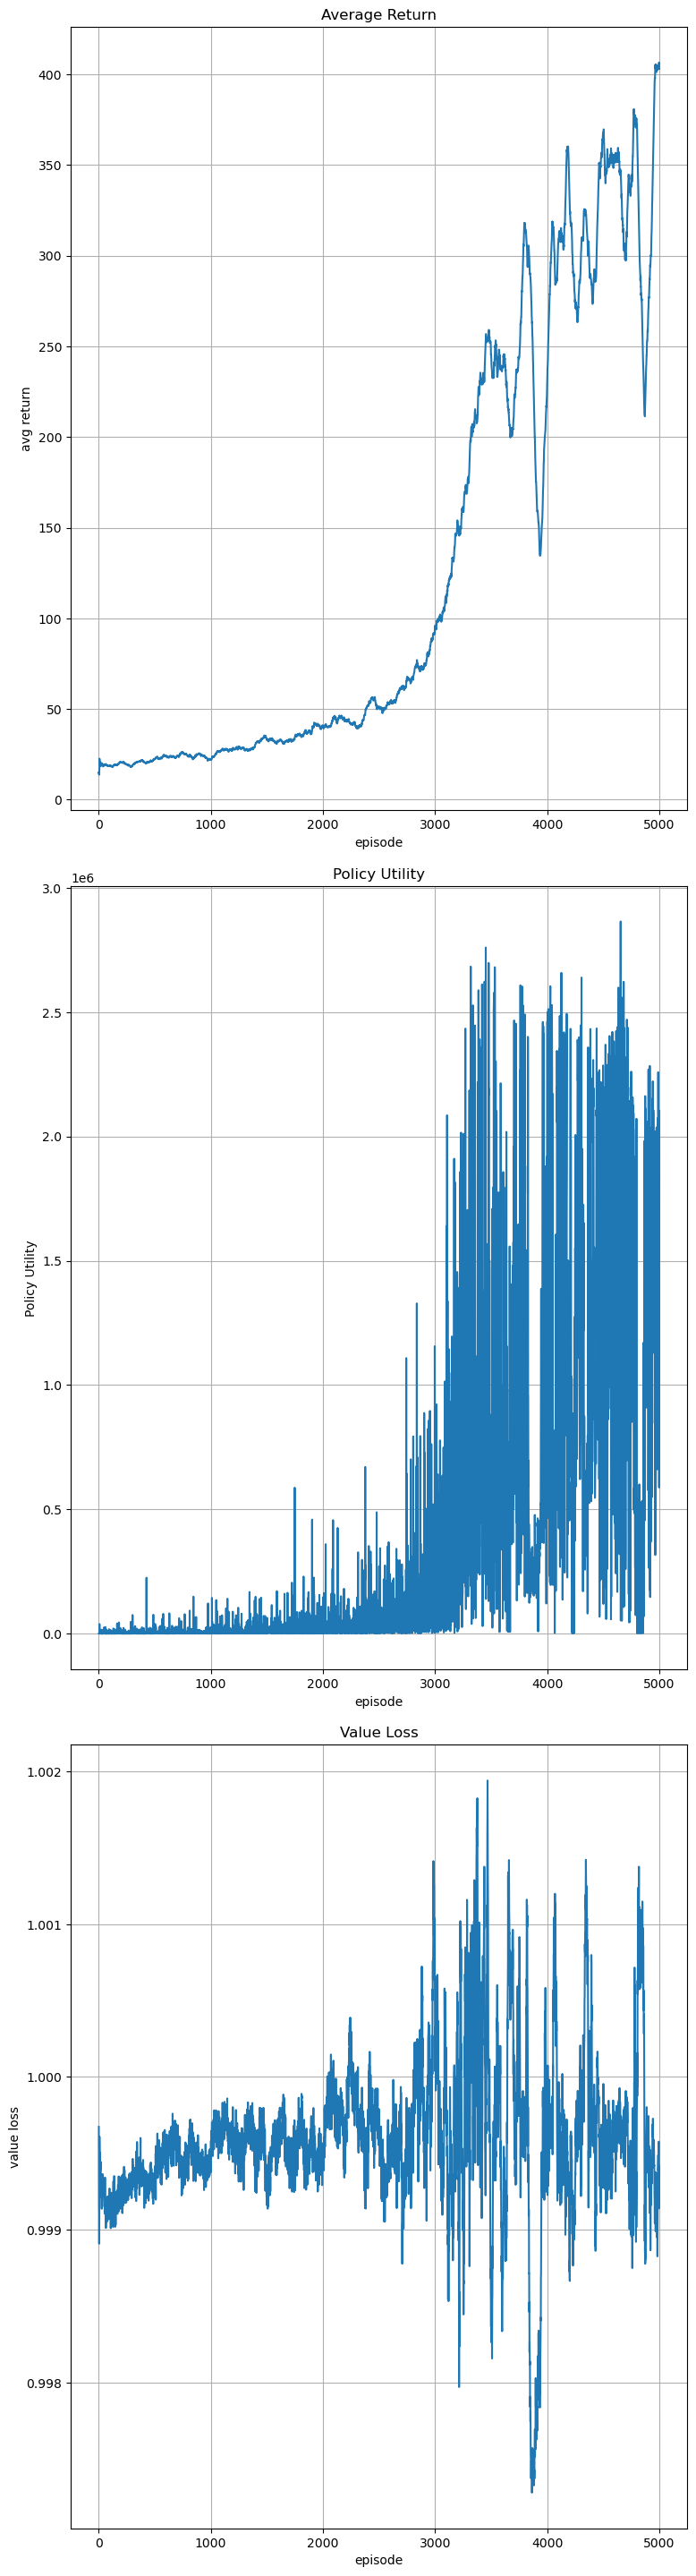

In [9]:
plt.figure(figsize=(8,29))

plt.subplot(3,1,1)
plt.title("Average Return")
plt.plot(list(range(1,n_episodes+1)), to_plot_avgreturn)
plt.grid()
plt.xlabel("episode")
plt.ylabel("avg return")

plt.subplot(3,1,2)
plt.title("Policy Utility")
plt.plot(list(range(1,n_episodes+1)), to_plot_utility)
plt.grid()
plt.xlabel("episode")
plt.ylabel("Policy Utility")

plt.subplot(3,1,3)
plt.title("Value Loss")
plt.plot(list(range(1,n_episodes+1)), to_plot_value_loss)
plt.grid()
plt.xlabel("episode")
plt.ylabel("value loss")

plt.tight_layout(pad=1.5)
plt.show()